In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
from sklearn.feature_selection import RFE

pd.set_option('display.max_columns', None)

In [73]:
df = pd.read_excel('../data/Maths.xlsx')

X = df.drop(columns=['G3'])
Y = df['G3'].to_numpy()

X = pd.get_dummies(X, drop_first=True)

# One-hot encode categorical variables (like 'sex', 'address', 'school')
print("Final feature set shape:", X.shape)
print(X.head(5))

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)

del X_temp
del Y_temp

print(f"Train: {X_train.shape}, Dev: {X_dev.shape}, Test: {X_test.shape}")
print(f"Train: {Y_train.shape}, Dev: {Y_dev.shape}, Test: {Y_test.shape}")

Final feature set shape: (397, 41)
   age  Medu  ...  internet_yes  romantic_yes
0   18     4  ...         False         False
1   17     1  ...          True         False
2   15     1  ...          True         False
3   15     4  ...          True          True
4   16     3  ...         False         False

[5 rows x 41 columns]
Train: (317, 41), Dev: (60, 41), Test: (20, 41)
Train: (317,), Dev: (60,), Test: (20,)


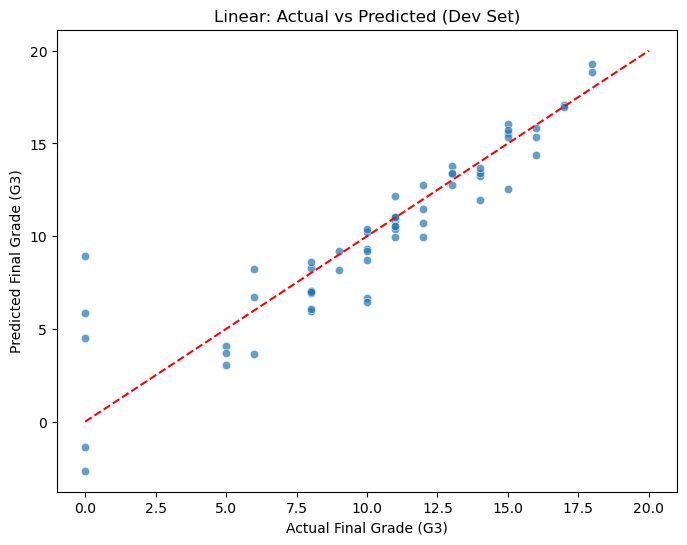

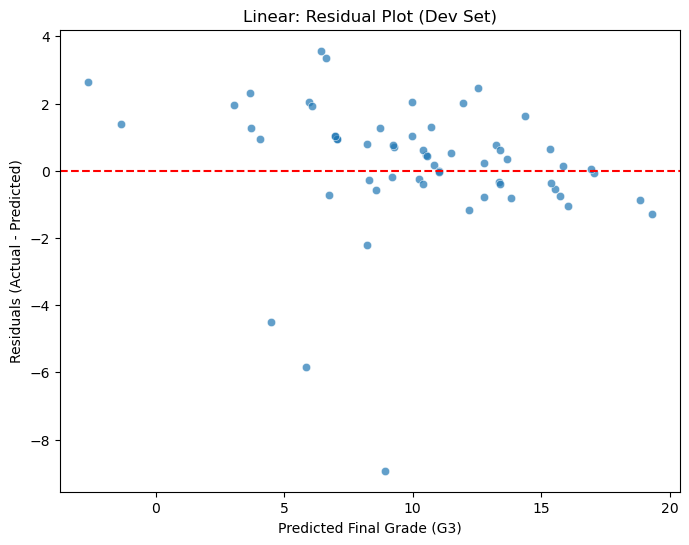

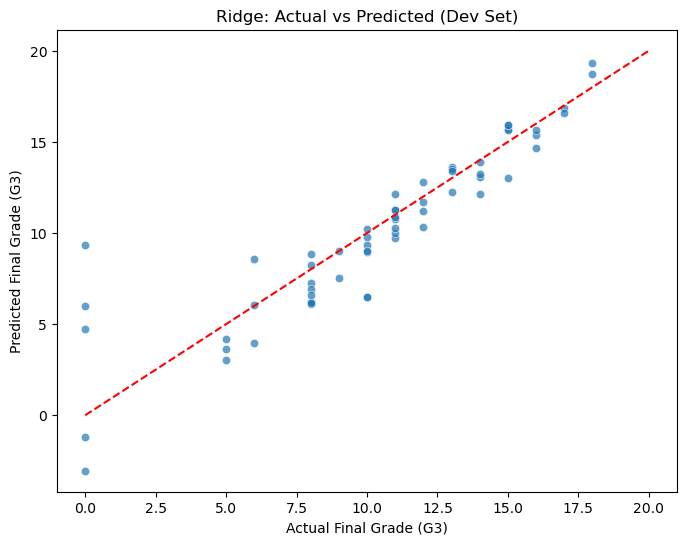

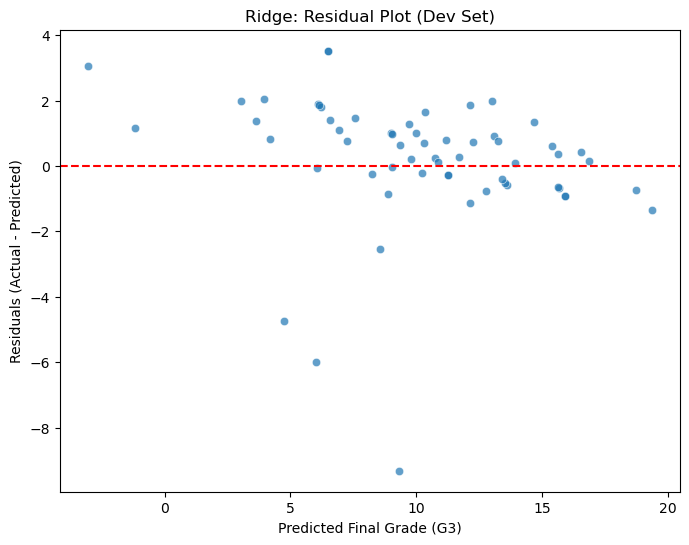

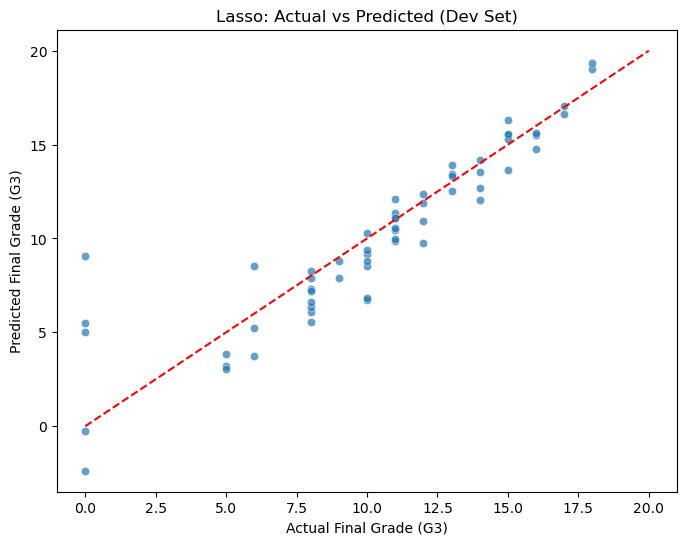

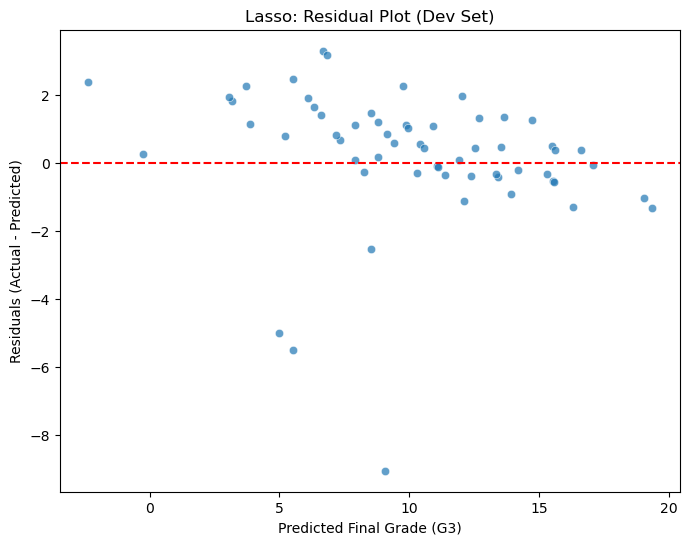

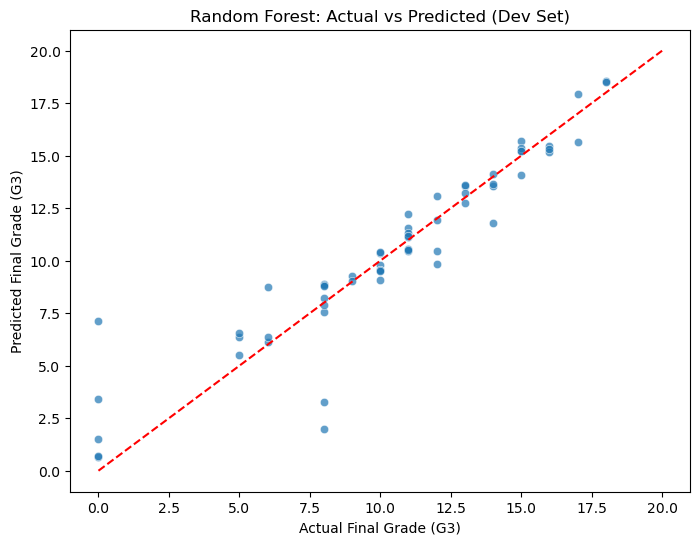

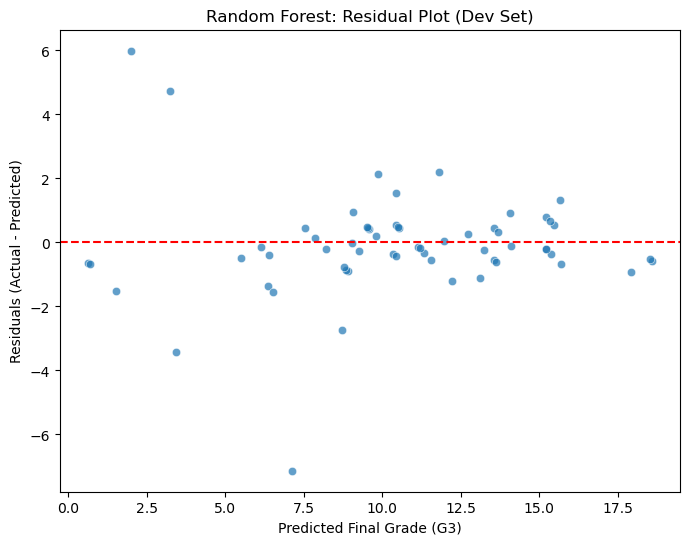

Dev Set Results:
               mean_squared_error  r2_score mean_absolute_error
Linear                  1.956986  0.813474            1.281224
Ridge                   2.016186  0.802018            1.321125
Lasso                   1.972581  0.810489            1.297025
Random Forest           1.651189  0.867212               0.982


In [109]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}

for name,model in models.items():
    rfe = RFE(model, n_features_to_select=15)
    rfe.fit(X_train, Y_train)
    y_dev_pred = rfe.predict(X_dev)

    selected_features = X_train.columns[rfe.support_]

    # Metrics
    mean_squared_error_value = np.sqrt(mean_squared_error(Y_dev, y_dev_pred))
    r2_score_value = r2_score(Y_dev, y_dev_pred)
    mean_absolute_error_value = mean_absolute_error(Y_dev, y_dev_pred)

    # --- Plot: Actual vs Predicted ---
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=Y_dev, y=y_dev_pred, alpha=0.7)
    plt.plot([0,20], [0,20], color="red", linestyle="--")  # perfect prediction line
    plt.xlabel("Actual Final Grade (G3)")
    plt.ylabel("Predicted Final Grade (G3)")
    plt.title(f"{name}: Actual vs Predicted (Dev Set)")
    plt.show()

    # --- Plot: Residuals ---
    residuals = Y_dev - y_dev_pred
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_dev_pred, y=residuals, alpha=0.7)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted Final Grade (G3)")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"{name}: Residual Plot (Dev Set)")
    plt.show()

    results[name] = {
        "selected_features": selected_features,
        "coef_" : model.coef_ if hasattr(model, 'coef_') else None,
        "mean_squared_error": mean_squared_error_value,
        "r2_score": r2_score_value,
        "mean_absolute_error": mean_absolute_error_value
    }

results_df = pd.DataFrame(results).T
print("Dev Set Results:\n", results_df.drop(columns=['coef_', 'selected_features']))


✅ Best Model: Random Forest
Selected Features: ['age', 'Medu', 'Fedu', 'studytime', 'famrel', 'freetime', 'goout', 'Walc', 'health', 'absences', 'G1', 'G2', 'reason_home', 'schoolsup_yes', 'activities_yes']

📊 Test Set Performance:
MAE: 0.55
RMSE: 0.77
R2: 0.97


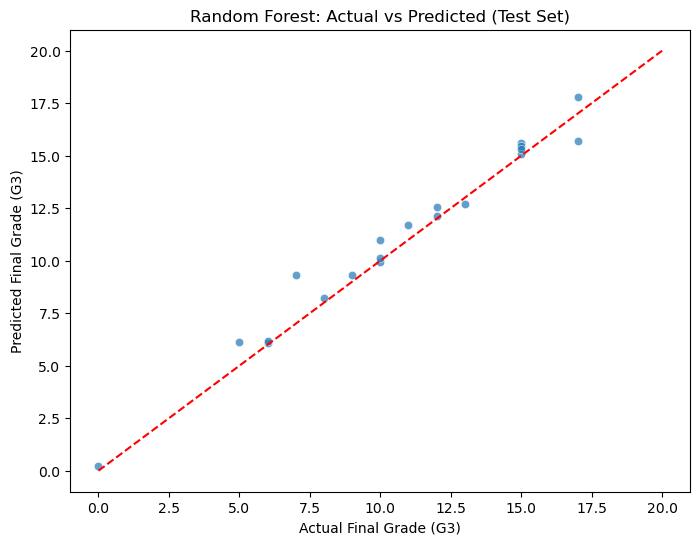

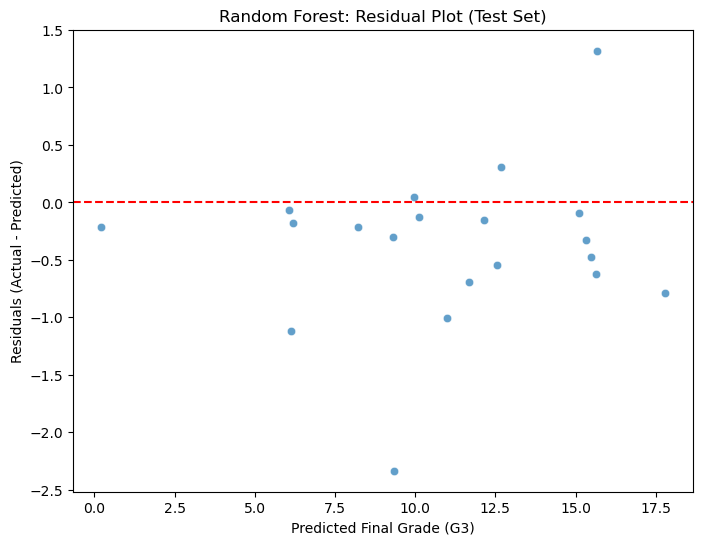

In [113]:
# Step 2: Pick best model (highest R2)
best_model_name = results_df['r2_score'].idxmax()
best_model_info = results[best_model_name]
best_features = list(best_model_info["selected_features"])  # convert Index to list

print(f"Best Model: {best_model_name}")
print(f"Selected Features: {best_features}")

# Step 3: Retrain best model on Train+Dev with selected features
X_train_dev = pd.concat([X_train, X_dev])
Y_train_dev = np.concatenate([Y_train, Y_dev])

best_model = models[best_model_name]
rfe_final = RFE(best_model, n_features_to_select=len(best_features))
rfe_final.fit(X_train_dev[best_features], Y_train_dev)

# Step 4: Evaluate on Test set
y_test_pred = rfe_final.predict(X_test[best_features])

mae_test = mean_absolute_error(Y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_pred))
r2_test = r2_score(Y_test, y_test_pred)

print("Test Set Performance:")
print(f"MAE: {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R2: {r2_test:.2f}")

# --- Plot: Actual vs Predicted (Test set) ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=Y_test, y=y_test_pred, alpha=0.7)
plt.plot([0,20], [0,20], color="red", linestyle="--")
plt.xlabel("Actual Final Grade (G3)")
plt.ylabel("Predicted Final Grade (G3)")
plt.title(f"{best_model_name}: Actual vs Predicted (Test Set)")
plt.show()

# --- Plot: Residuals (Test set) ---
residuals_test = Y_test - y_test_pred
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_pred, y=residuals_test, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Final Grade (G3)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"{best_model_name}: Residual Plot (Test Set)")
plt.show()
